# Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Ej 6

## Arquitectura 1 

In [2]:


class Dense_Layer():
    def __init__(self, input_size, output_size, activation=None):
        self.activation = activation

        # Inicialización adaptada
        if activation == 'relu':
            scale = np.sqrt(2.0 / input_size)
        else:
            scale = np.sqrt(1.0 / input_size)
        self.weights = np.random.randn(input_size, output_size) * scale
        self.bias = np.zeros((1, output_size))

    def _activate(self, z):
        if self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            return z

    def _activate_grad(self, z):
        if self.activation == 'relu':
            grad = np.zeros_like(z)
            grad[z > 0] = 1
            return grad
        elif self.activation == 'sigmoid':
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif self.activation == 'tanh':
            t = np.tanh(z)
            return 1 - t**2
        else:
            return np.ones_like(z)

    def forward(self, x):
        self.x = x
        self.z = np.dot(x, self.weights) + self.bias
        self.a = self._activate(self.z)
        return self.a

    def backward(self, dout):
        dz = dout * self._activate_grad(self.z)
        self.dW = np.dot(self.x.T, dz)
        self.db = np.sum(dz, axis=0, keepdims=True)
        dx = np.dot(dz, self.weights.T)
        return dx

    def step(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db


class NeuralNet():
    def __init__(self, lr=1e-2):
        self.List_layers = []
        self.lr = lr

    def add_layer(self, layer):
        self.List_layers.append(layer)

    def forward(self, x):
        for layer in self.List_layers:
            x = layer.forward(x)
        return x

    def backward(self, dloss_dy):
        grad = dloss_dy
        for layer in reversed(self.List_layers):
            grad = layer.backward(grad)

    def step(self):
        for layer in self.List_layers:
            layer.step(self.lr)

    def compute_loss_and_grad(self, y_pred, y_true):
        N = y_true.shape[0]
        diff = (y_pred - y_true)
        loss = np.mean(diff**2)
        dloss_dy = (2.0 / N) * diff
        return loss, dloss_dy

    def train_step(self, x_batch, y_batch):
        y_pred = self.forward(x_batch)
        loss, dloss_dy = self.compute_loss_and_grad(y_pred, y_batch)
        self.backward(dloss_dy)
        self.step()
        return loss
    
    def accuracy(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.sign(y_pred)
        y_true_labels = np.sign(y)
        return np.mean(y_pred_labels == y_true_labels)
    


# === Entrenamiento XOR centrado ===
net = NeuralNet(lr=0.1)
net.add_layer(Dense_Layer(2, 2, activation='tanh'))
net.add_layer(Dense_Layer(2, 1, activation='tanh'))

x_train = np.array([[-1,-1],
                    [-1, 1],
                    [ 1,-1],
                    [ 1, 1]], dtype=float)

y_train = np.array([[-1],
                    [ 1],
                    [ 1],
                    [-1]], dtype=float)

losses = []
accuracies = [0]

while accuracies[-1] < 1.0:
    loss = net.train_step(x_train, y_train)
    losses.append(loss)
    acc = net.accuracy(x_train, y_train)
    accuracies.append(acc)



# test final
correct = 0
print("\nPredicciones finales:")
for x, ytrue in zip(x_train, y_train):
    y_pred = net.forward(x.reshape(1,-1))
    print(f"Input: {x}, Pred: {y_pred[0,0]:.3f}, Rounded: {np.sign(y_pred[0,0])}, True: {ytrue[0]}")
    if np.sign(y_pred[0,0]) == ytrue[0]:
        correct += 1
print(f"\nCantidad de predicciones correctas: {correct} de {len(y_train)}")




Predicciones finales:
Input: [-1. -1.], Pred: -0.417, Rounded: -1.0, True: -1.0
Input: [-1.  1.], Pred: 0.013, Rounded: 1.0, True: 1.0
Input: [ 1. -1.], Pred: 0.425, Rounded: 1.0, True: 1.0
Input: [1. 1.], Pred: -0.287, Rounded: -1.0, True: -1.0

Cantidad de predicciones correctas: 4 de 4


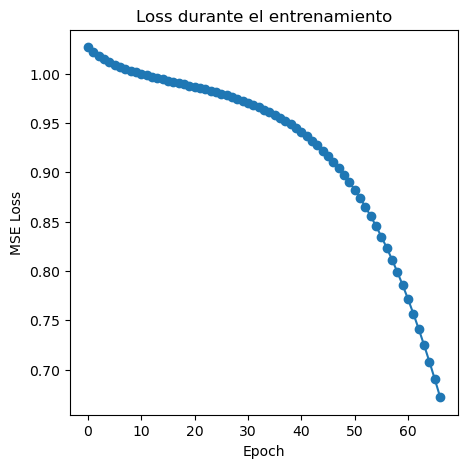

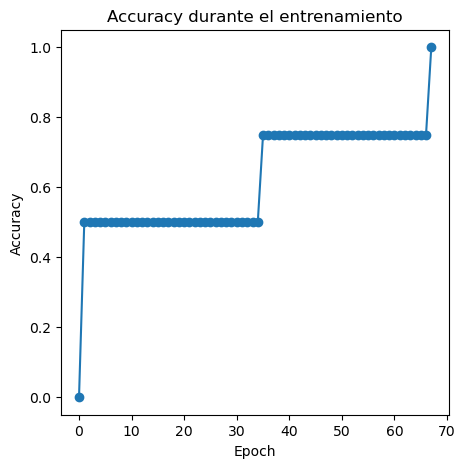

In [26]:
plt.figure(figsize=(5,5))
plt.plot(losses, '-o')
plt.title("Loss durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.figure(figsize=(5,5))
plt.plot(accuracies, '-o')
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


## Arquitectura 2

In [27]:
import numpy as np

class Dense_Layer_2():
    def __init__(self, input_sizes, output_size, activation=None, input_ids=None):
        """
        input_sizes: lista con las dimensiones de CADA entrada que va a tomar esta capa
                     por ejemplo [2] si toma sólo X con dim 2
                     o [2,1] si toma X(2) y h(1) y las concatena → total 3
        output_size: dimensión de salida de esta capa
        activation: 'relu', 'sigmoid', 'tanh' o None
        input_ids: lista con los índices de activación que esta capa va a leer del grafo.
                   Debe tener la misma longitud que input_sizes.
                   Ej: [0]    → tomo sólo activación[0]
                       [0,1]  → concateno activación[0] y activación[1]
        """
        assert len(input_sizes) == len(input_ids), "input_sizes y input_ids deben matchear"
        self.activation = activation
        self.input_ids = input_ids              # ej [0] o [0,1]

        # guardo las dims de cada rama que entra
        self.branch_input_dims = input_sizes[:]  # ej [2] o [2,1]

        # tamaño total de entrada luego de concatenar
        self.in_dim = sum(input_sizes)
        self.out_dim = output_size

        # init tipo He/Xavier simple
        if activation == 'relu':
            scale = np.sqrt(2.0 / self.in_dim)
        else:
            scale = np.sqrt(1.0 / self.in_dim)

        self.weights = np.random.randn(self.in_dim, self.out_dim) * scale
        self.bias    = np.zeros((1, self.out_dim))

        # caches para backward
        self.concat_input = None  # (batch, in_dim)
        self.z = None             # (batch, out_dim)
        self.a = None             # (batch, out_dim)

        # grads
        self.dW = None
        self.db = None

    def _activate(self, z):
        if self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            return z

    def _activate_grad(self, z):
        if self.activation == 'relu':
            grad = np.zeros_like(z)
            grad[z > 0] = 1
            return grad
        elif self.activation == 'sigmoid':
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif self.activation == 'tanh':
            t = np.tanh(z)
            return 1 - t**2
        else:
            return np.ones_like(z)

    def forward(self, activations):
        """
        activations: lista con TODAS las activaciones anteriores en la red.
                     activations[0] = input original
                     activations[1] = salida de la 1er capa, etc.

        Esta capa toma activations[idx] para idx en self.input_ids,
        las concatena y les aplica una Dense + activación.
        """
        inputs = [activations[i] for i in self.input_ids]   # cada uno (batch, dim_i)
        concat_x = np.concatenate(inputs, axis=1)           # (batch, in_dim)
        self.concat_input = concat_x

        self.z = np.dot(concat_x, self.weights) + self.bias  # (batch, out_dim)
        self.a = self._activate(self.z)
        return self.a

    def backward(self, grad_out):
        """
        grad_out: dL/d(self.a)  shape (batch, out_dim)

        Devuelve:
          grads_dict: dict {idx: grad w.r.t activations[idx] }
          donde idx son índices de activaciones de entrada (input_ids)
        """
        # dL/dz
        dz = grad_out * self._activate_grad(self.z)     # (batch, out_dim)

        # grad pesos y bias
        self.dW = np.dot(self.concat_input.T, dz)       # (in_dim, out_dim)
        self.db = np.sum(dz, axis=0, keepdims=True)     # (1, out_dim)

        # grad hacia el input concatenado
        dconcat = np.dot(dz, self.weights.T)            # (batch, in_dim)

        # repartir dconcat en las ramas originales
        grads_dict = {}
        start = 0
        for in_id, in_size in zip(self.input_ids, self.branch_input_dims):
            end = start + in_size
            piece = dconcat[:, start:end]  # grad w.r.t activations[in_id]
            if in_id in grads_dict:
                grads_dict[in_id] += piece
            else:
                grads_dict[in_id] = piece
            start = end

        return grads_dict

    def step(self, lr):
        self.weights -= lr * self.dW
        self.bias    -= lr * self.db


class Concat_Layer_2():
    def __init__(self, input_ids, input_sizes):
        """
        input_ids: qué activaciones tomar, ej [0,1]
        input_sizes: sus dimensiones respectivas, ej [2,1]
        """
        assert len(input_ids) == len(input_sizes)
        self.input_ids = input_ids
        self.branch_input_dims = input_sizes
        self.out_dim = sum(input_sizes)

        # cache forward
        self.last_inputs = None  # lista de arrays individuales
        self.output = None

    def forward(self, activations):
        xs = [activations[i] for i in self.input_ids]  # p.ej [X, h]
        self.last_inputs = xs
        self.output = np.concatenate(xs, axis=1)      # (batch, out_dim)
        return self.output

    def backward(self, grad_out):
        """
        grad_out: dL/d(concat_output) shape (batch, out_dim)

        Devuelvo dict {idx: grad} con gradientes hacia
        cada activación usada en la concatenación.
        """
        grads_dict = {}
        start = 0
        for in_id, in_size in zip(self.input_ids, self.branch_input_dims):
            end = start + in_size
            piece = grad_out[:, start:end]  # grad respecto activations[in_id]
            if in_id in grads_dict:
                grads_dict[in_id] += piece
            else:
                grads_dict[in_id] = piece
            start = end

        return grads_dict

    def step(self, lr):
        # no trainable params
        pass


class NeuralNet_2():
    def __init__(self, lr=1e-2):
        self.layers = []
        self.lr = lr

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x0):
        """
        activations[0] = x0 (input crudo)
        activations[1] = salida de la primera capa
        activations[2] = salida de la segunda capa
        ...
        y_pred = activations[-1]
        """
        activations = [x0]
        for layer in self.layers:
            out = layer.forward(activations)
            activations.append(out)
        y_pred = activations[-1]
        return activations, y_pred

    def compute_loss_and_grad(self, y_pred, y_true):
        """
        MSE para targets tipo [-1,1]
        """
        N = y_true.shape[0]
        diff = (y_pred - y_true)
        loss = np.mean(diff**2)
        dloss_dy = (2.0 / N) * diff  # dL/d(y_pred)
        return loss, dloss_dy

    def backward(self, activations, dloss_dy):
        """
        Propaga hacia atrás en el grafo.
        grads_wrt_activation[i] = dL/d activations[i]
        """
        grads_wrt_activation = {}
        last_idx = len(activations) - 1
        grads_wrt_activation[last_idx] = dloss_dy  # grad en la salida final

        # recorrer capas al revés
        # capa k produce activations[k+1]
        for layer_idx in reversed(range(len(self.layers))):
            layer = self.layers[layer_idx]
            out_activation_idx = layer_idx + 1  # índice de su salida en activations

            grad_out = grads_wrt_activation[out_activation_idx]

            grads_dict = layer.backward(grad_out)
            # sumamos contribuciones para cada activación anterior
            for act_idx, g in grads_dict.items():
                if act_idx in grads_wrt_activation:
                    grads_wrt_activation[act_idx] += g
                else:
                    grads_wrt_activation[act_idx] = g

        return grads_wrt_activation

    def step(self):
        for layer in self.layers:
            layer.step(self.lr)

    def train_step(self, x_batch, y_batch):
        activations, y_pred = self.forward(x_batch)
        loss, dloss_dy = self.compute_loss_and_grad(y_pred, y_batch)
        self.backward(activations, dloss_dy)
        self.step()
        return loss
    
    def accuracy(self, x, y):
        y_pred = self.forward(x)[1]
        y_pred_labels = np.sign(y_pred)
        y_true_labels = np.sign(y)
        return np.mean(y_pred_labels == y_true_labels)
    


In [28]:
# Capa 0: h = tanh(W_h X + b_h)
layer_hidden = Dense_Layer_2(
    input_sizes=[2],     # usa sólo X que tiene dim 2
    output_size=1,       # produce h de dim 1
    activation='tanh',
    input_ids=[0]        # lee activations[0] = input original
)

# Capa 1: concat = [X, h]
layer_concat = Concat_Layer_2(
    input_ids=[0, 1],      # activations[0] = X, activations[1] = h
    input_sizes=[2, 1]     # dim(X)=2, dim(h)=1 → concat dim=3
)

# Capa 2: y = tanh(W_out concat + b_out)
layer_out = Dense_Layer_2(
    input_sizes=[3],     # toma sólo activations[2] (la concat)
    output_size=1,
    activation='tanh',
    input_ids=[2]        # lee activations[2]
)

net = NeuralNet_2(lr=0.1)
net.add_layer(layer_hidden)   # activations[1] = h
net.add_layer(layer_concat)   # activations[2] = concat(X,h)
net.add_layer(layer_out)      # activations[3] = y_pred final

# XOR centrado en [-1,1]
x_train = np.array([[-1,-1],
                    [-1, 1],
                    [ 1,-1],
                    [ 1, 1]], dtype=float)

y_train = np.array([[-1],
                    [ 1],
                    [ 1],
                    [-1]], dtype=float)

# train loop

losses = []
accuracies = [0]

while accuracies[-1] < 1.0:
    loss = net.train_step(x_train, y_train)
    losses.append(loss)
    acc = net.accuracy(x_train, y_train)
    accuracies.append(acc)

# test
activations, y_pred_all = net.forward(x_train)
correct = 0
print("\nPredicciones finales:")
for x, yhat, ytrue in zip(x_train, y_pred_all, y_train):
    pred_sign = np.sign(yhat[0])
    print(f"Input: {x}, Pred: {yhat[0]:.3f}, Rounded: {pred_sign:.0f}, True: {ytrue[0]:.0f}")
    if pred_sign == ytrue[0]:
        correct += 1
print(f"\nCantidad de predicciones correctas: {correct} de {len(y_train)}")


Predicciones finales:
Input: [-1. -1.], Pred: -0.154, Rounded: -1, True: -1
Input: [-1.  1.], Pred: 0.209, Rounded: 1, True: 1
Input: [ 1. -1.], Pred: 0.205, Rounded: 1, True: 1
Input: [1. 1.], Pred: -0.004, Rounded: -1, True: -1

Cantidad de predicciones correctas: 4 de 4


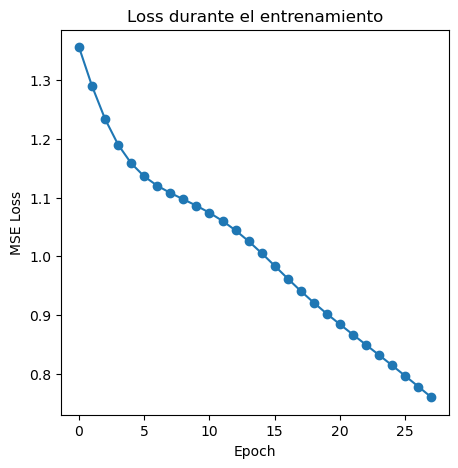

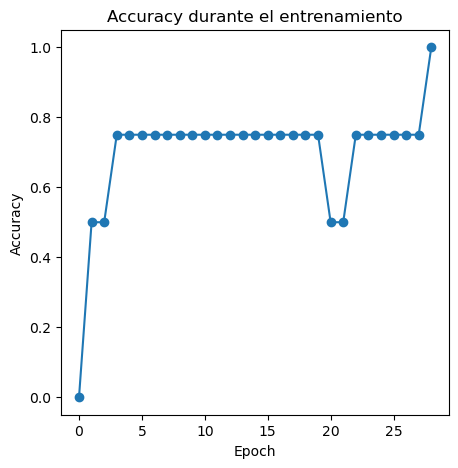

In [30]:
plt.figure(figsize=(5,5))

plt.plot(losses, '-o')
plt.title("Loss durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.figure(figsize=(5,5))
plt.plot(accuracies, '-o')
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#   Ej 7

In [3]:
import numpy as np

class Dense_Layer():
    def __init__(self, input_size, output_size, activation=None):
        self.activation = activation

        # Inicialización adaptada
        if activation == 'relu':
            scale = np.sqrt(2.0 / input_size)
        else:
            scale = np.sqrt(1.0 / input_size)
        self.weights = np.random.randn(input_size, output_size) * scale
        self.bias = np.zeros((1, output_size))

    def _activate(self, z):
        if self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            return z

    def _activate_grad(self, z):
        if self.activation == 'relu':
            grad = np.zeros_like(z)
            grad[z > 0] = 1
            return grad
        elif self.activation == 'sigmoid':
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif self.activation == 'tanh':
            t = np.tanh(z)
            return 1 - t**2
        else:
            return np.ones_like(z)

    def forward(self, x):
        self.x = x
        self.z = np.dot(x, self.weights) + self.bias
        self.a = self._activate(self.z)
        return self.a

    def backward(self, dout):
        dz = dout * self._activate_grad(self.z)
        self.dW = np.dot(self.x.T, dz)
        self.db = np.sum(dz, axis=0, keepdims=True)
        dx = np.dot(dz, self.weights.T)
        return dx

    def step(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db


class NeuralNet():
    def __init__(self, lr=1e-2):
        self.List_layers = []
        self.lr = lr

    def add_layer(self, layer):
        self.List_layers.append(layer)

    def forward(self, x):
        for layer in self.List_layers:
            x = layer.forward(x)
        return x

    def backward(self, dloss_dy):
        grad = dloss_dy
        for layer in reversed(self.List_layers):
            grad = layer.backward(grad)

    def step(self):
        for layer in self.List_layers:
            layer.step(self.lr)

    def compute_loss_and_grad(self, y_pred, y_true):
        N = y_true.shape[0]
        diff = (y_pred - y_true)
        loss = np.mean(diff**2)
        dloss_dy = (2.0 / N) * diff
        return loss, dloss_dy

    def train_step(self, x_batch, y_batch):
        y_pred = self.forward(x_batch)
        loss, dloss_dy = self.compute_loss_and_grad(y_pred, y_batch)
        self.backward(dloss_dy)
        self.step()
        return loss
    
    def accuracy(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.sign(y_pred)
        y_true_labels = np.sign(y)
        return np.mean(y_pred_labels == y_true_labels)


In [9]:
N = 10
#todas las convinaciones de -1 y 1 de tamaño N
from itertools import product
x_train = np.array(list(product([-1, 1], repeat=N)))
y_train = []
for i in range(len(x_train)):
    y_train.append( np.prod(x_train[i]) )
y_train = np.array(y_train).reshape(-1,1)

# print("Datos de entrenamiento:")
# for x, y in zip(x_train, y_train):
#     print(f"Input: {x}, Target: {y[0]}")

In [10]:
N = 10
N_h = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

losses = []
accuracies = []

for N_h_ in N_h:
    net = NeuralNet(lr=0.1)
    net.add_layer(Dense_Layer(N, N_h_, activation='tanh'))
    net.add_layer(Dense_Layer(N_h_, 1, activation='tanh'))

    losses_Nh = []
    accuracies_Nh = [0]

    for epoch in range(20000):
        loss = net.train_step(x_train, y_train)
        losses_Nh.append(loss)
        acc = net.accuracy(x_train, y_train)
        accuracies_Nh.append(acc)

        if epoch % 1000 == 0:
            print(f"N_h={N_h_}, Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    losses.append(losses_Nh)
    accuracies.append(accuracies_Nh)

N_h=10, Epoch 0, Loss: 1.2703, Accuracy: 0.5000
N_h=10, Epoch 1000, Loss: 1.0001, Accuracy: 0.4980
N_h=10, Epoch 2000, Loss: 1.0000, Accuracy: 0.5000
N_h=10, Epoch 3000, Loss: 1.0000, Accuracy: 0.5020
N_h=10, Epoch 4000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 5000, Loss: 1.0000, Accuracy: 0.5000
N_h=10, Epoch 6000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 7000, Loss: 1.0000, Accuracy: 0.5020
N_h=10, Epoch 8000, Loss: 1.0000, Accuracy: 0.5020
N_h=10, Epoch 9000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 10000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 11000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 12000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 13000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 14000, Loss: 1.0000, Accuracy: 0.5029
N_h=10, Epoch 15000, Loss: 1.0000, Accuracy: 0.5029
N_h=10, Epoch 16000, Loss: 1.0000, Accuracy: 0.5000
N_h=10, Epoch 17000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 18000, Loss: 1.0000, Accuracy: 0.5010
N_h=10, Epoch 19000, Loss

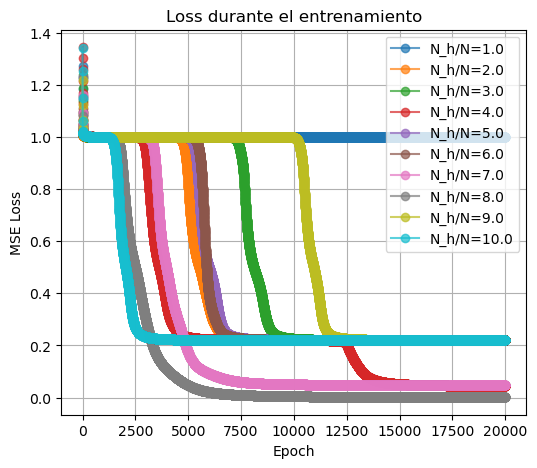

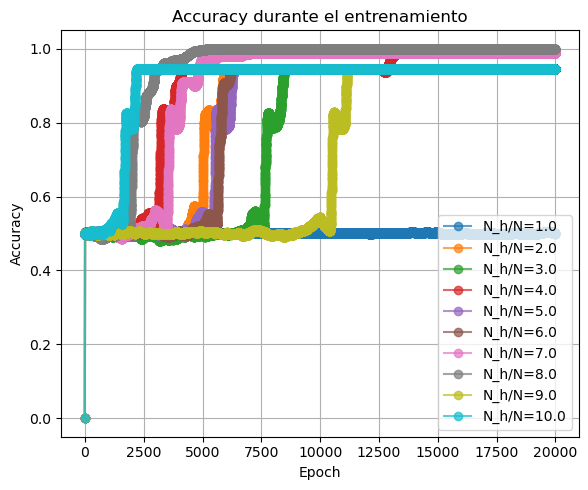

In [22]:
plt.figure(figsize=(6,5))
for i in range(len(N_h)):
    plt.plot(losses[i], '-o', label=f"N_h/N={N_h[i]/10}", alpha=0.7)
plt.title("Loss durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(loc='best')
plt.grid(True)

plt.figure(figsize=(6,5))
for i in range(len(N_h)):
    plt.plot(accuracies[i], '-o', label=f"N_h/N={N_h[i]/10}", alpha=0.7)
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()
